In [13]:
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np
import torch
import torchvision.transforms as T

class PathoSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

        # Only keep pairs that match by filename number
        base_mask_names = set(os.path.splitext(f)[0] for f in mask_files)
        self.paired_files = [
            (f, f.replace('.jpg', '.png')) for f in image_files
            if os.path.splitext(f)[0] in base_mask_names
        ]

    def __len__(self):
        return len(self.paired_files)

    def __getitem__(self, idx):
        img_filename, mask_filename = self.paired_files[idx]
        img_path = os.path.join(self.image_dir, img_filename)
        mask_path = os.path.join(self.mask_dir, mask_filename)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        image = T.ToTensor()(image)
        mask = torch.from_numpy(np.array(mask)).long()

        return image, mask


In [14]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # Pretrained backbone
    encoder_weights="imagenet",     
    in_channels=3,
    classes=3,                      # background, petri dish, pathogen
)

In [15]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

train_dataset = PathoSegDataset(
    image_dir='images_224_rename',
    mask_dir='labels/final_labels'
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [16]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}")

Epoch [1/20], Loss: 18.4730
Epoch [2/20], Loss: 13.2873
Epoch [3/20], Loss: 10.8537
Epoch [4/20], Loss: 9.3154
Epoch [5/20], Loss: 8.2518
Epoch [6/20], Loss: 7.3973
Epoch [7/20], Loss: 6.6934
Epoch [8/20], Loss: 6.0748
Epoch [9/20], Loss: 5.5621
Epoch [10/20], Loss: 5.1291
Epoch [11/20], Loss: 4.7586
Epoch [12/20], Loss: 4.4379
Epoch [13/20], Loss: 4.1503
Epoch [14/20], Loss: 3.8949
Epoch [15/20], Loss: 3.6746
Epoch [16/20], Loss: 3.4784
Epoch [17/20], Loss: 3.2789
Epoch [18/20], Loss: 3.1216
Epoch [19/20], Loss: 2.9575
Epoch [20/20], Loss: 2.7936


In [17]:
print("Number of images:", len(os.listdir('images_224_rename')))
print("Number of masks:", len(os.listdir('labels/final_labels')))

Number of images: 284
Number of masks: 51


In [18]:
print("First few image files:", sorted(os.listdir('images_224_rename'))[:5])
print("First few mask files:", sorted(os.listdir('labels/final_labels'))[:5])

First few image files: ['.ipynb_checkpoints', '001.jpg', '002.jpg', '003.jpg', '004.jpg']
First few mask files: ['.ipynb_checkpoints', '001.png', '002.png', '003.png', '004.png']


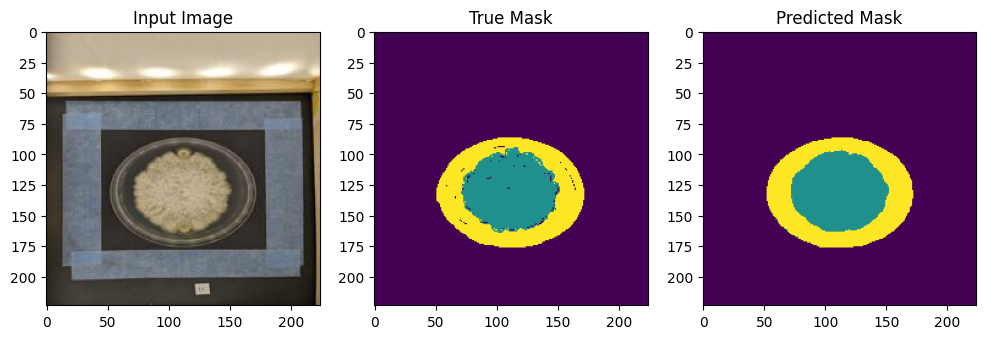

In [19]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    img, true_mask = train_dataset[0]
    pred = model(img.unsqueeze(0).to(device))
    pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Input Image"); plt.imshow(img.permute(1,2,0))
plt.subplot(1,3,2); plt.title("True Mask"); plt.imshow(true_mask)
plt.subplot(1,3,3); plt.title("Predicted Mask"); plt.imshow(pred_mask)
plt.show()


In [20]:
import os
import torch
import numpy as np
from PIL import Image

# 1) Make sure your folder for predictions exists.
os.makedirs("labels/automated_labels", exist_ok=True)

model.eval()
with torch.no_grad():
    for idx in range(len(train_dataset)):
        # 2) Grab the image and (optionally) the mask from your dataset.
        img, _ = train_dataset[idx]

        # 3) Run prediction on the GPU (if available).
        img = img.unsqueeze(0).to(device)  # shape: (1, C, H, W)
        pred = model(img)                 # shape: (1, num_classes, H, W)

        # 4) Convert to 2D predicted labels [H x W].
        pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy().astype(np.uint8)

        # 5) Identify the correct filename to save under.
        #    - We'll reuse the original mask_filename from paired_files,
        #      so the predicted mask line-ups with the input filename.
        #    - If you just want to rename systematically, you can do so here.
        img_filename, mask_filename = train_dataset.paired_files[idx]

        # 6) Save as an image in PNG format (or whichever format you'd like).
        save_path = os.path.join("labels/automated_labels", mask_filename)
        Image.fromarray(pred_mask).save(save_path)

        # Optional: Print progress or debugging info
        print(f"Saved predicted mask as: {save_path}")


Saved predicted mask as: labels/automated_labels/001.png
Saved predicted mask as: labels/automated_labels/002.png
Saved predicted mask as: labels/automated_labels/003.png
Saved predicted mask as: labels/automated_labels/004.png
Saved predicted mask as: labels/automated_labels/005.png
Saved predicted mask as: labels/automated_labels/006.png
Saved predicted mask as: labels/automated_labels/007.png
Saved predicted mask as: labels/automated_labels/008.png
Saved predicted mask as: labels/automated_labels/009.png
Saved predicted mask as: labels/automated_labels/010.png
Saved predicted mask as: labels/automated_labels/011.png
Saved predicted mask as: labels/automated_labels/012.png
Saved predicted mask as: labels/automated_labels/013.png
Saved predicted mask as: labels/automated_labels/014.png
Saved predicted mask as: labels/automated_labels/015.png
Saved predicted mask as: labels/automated_labels/016.png
Saved predicted mask as: labels/automated_labels/017.png
Saved predicted mask as: labels

===== START TRAINING =====
Epoch [1/20], Loss: 10.9596
Epoch [2/20], Loss: 7.5594
Epoch [3/20], Loss: 5.8354
Epoch [4/20], Loss: 4.8349
Epoch [5/20], Loss: 4.1268
Epoch [6/20], Loss: 3.5883
Epoch [7/20], Loss: 3.1415
Epoch [8/20], Loss: 2.7920
Epoch [9/20], Loss: 2.5045
Epoch [10/20], Loss: 2.2281
Epoch [11/20], Loss: 2.0156
Epoch [12/20], Loss: 1.8474
Epoch [13/20], Loss: 1.6831
Epoch [14/20], Loss: 1.5408
Epoch [15/20], Loss: 1.4217
Epoch [16/20], Loss: 1.3255
Epoch [17/20], Loss: 1.2255
Epoch [18/20], Loss: 1.1509
Epoch [19/20], Loss: 1.0781
Epoch [20/20], Loss: 1.0149
===== TRAINING FINISHED =====


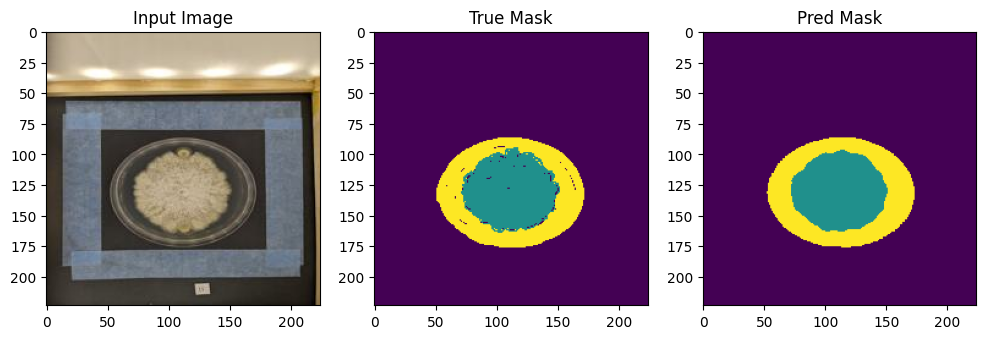

===== START INFERENCE ON ALL IMAGES =====
Saved predicted mask to labels/automated_labels_2/001_pred.png
Saved predicted mask to labels/automated_labels_2/002_pred.png
Saved predicted mask to labels/automated_labels_2/003_pred.png
Saved predicted mask to labels/automated_labels_2/004_pred.png
Saved predicted mask to labels/automated_labels_2/005_pred.png
Saved predicted mask to labels/automated_labels_2/006_pred.png
Saved predicted mask to labels/automated_labels_2/007_pred.png
Saved predicted mask to labels/automated_labels_2/008_pred.png
Saved predicted mask to labels/automated_labels_2/009_pred.png
Saved predicted mask to labels/automated_labels_2/010_pred.png
Saved predicted mask to labels/automated_labels_2/011_pred.png
Saved predicted mask to labels/automated_labels_2/012_pred.png
Saved predicted mask to labels/automated_labels_2/013_pred.png
Saved predicted mask to labels/automated_labels_2/014_pred.png
Saved predicted mask to labels/automated_labels_2/015_pred.png
Saved predict

In [25]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

################################################################
# 1) SUPERVISED DATASET: REQUIRES IMAGE/MASK PAIRS
################################################################
class PathoSegDataset(Dataset):
    """
    For supervised training: Loads only those image-mask pairs
    whose filenames match (by base name).
    """
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

        # Only keep pairs that match by filename number
        base_mask_names = set(os.path.splitext(f)[0] for f in mask_files)
        self.paired_files = [
            (f, f.replace('.jpg', '.png')) for f in image_files
            if os.path.splitext(f)[0] in base_mask_names
        ]

    def __len__(self):
        return len(self.paired_files)

    def __getitem__(self, idx):
        img_filename, mask_filename = self.paired_files[idx]
        img_path = os.path.join(self.image_dir, img_filename)
        mask_path = os.path.join(self.mask_dir, mask_filename)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transform is not None:
            image = self.transform(image)
        else:
            image = T.ToTensor()(image)

        # Convert mask to a long tensor for CrossEntropyLoss
        mask = torch.from_numpy(np.array(mask)).long()

        return image, mask

################################################################
# 2) INFERENCE-ONLY DATASET: NO MASKS REQUIRED
################################################################
class InferenceDataset(Dataset):
    """
    For unlabeled images: Loads *all* .jpg files in a folder
    so you can run inference on them, even if no mask exists.
    """
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = sorted(
            [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        )

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_filename)

        image = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        else:
            image = T.ToTensor()(image)

        return image, img_filename

################################################################
# 3) SET UP MODEL: SMP UNet
################################################################
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=3,  # background, petri dish, pathogen
)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

################################################################
# 4) TRAINING (OPTIONAL) - ONLY IF YOU HAVE LABELS
################################################################
# Create dataset & loader for training images that DO have masks
train_dataset = PathoSegDataset(
    image_dir='images_224_rename',
    mask_dir='labels/final_labels'
)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 20

print("===== START TRAINING =====")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}")

print("===== TRAINING FINISHED =====")

# (Optional) Save the trained weights
# torch.save(model.state_dict(), "my_trained_unet.pth")

################################################################
# 5) QUICK VISUAL CHECK ON ONE TRAIN IMAGE (OPTIONAL)
################################################################
if len(train_dataset) > 0:
    model.eval()
    with torch.no_grad():
        img, true_mask = train_dataset[0]
        pred = model(img.unsqueeze(0).to(device))
        pred_mask = torch.argmax(pred.squeeze(), dim=0).cpu().numpy()

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("Input Image"); plt.imshow(img.permute(1,2,0))
    plt.subplot(1,3,2); plt.title("True Mask");   plt.imshow(true_mask)
    plt.subplot(1,3,3); plt.title("Pred Mask");   plt.imshow(pred_mask)
    plt.show()

################################################################
# 6) INFERENCE (PREDICT FOR *ALL* IMAGES, LABELED OR NOT)
################################################################
# - If you've just trained, great; otherwise, load your weights:
#   model.load_state_dict(torch.load("my_trained_unet.pth"))

# Create the inference dataset for *every* .jpg in images_224_rename
inference_dataset = InferenceDataset("images_224_rename")
inference_loader = DataLoader(inference_dataset, batch_size=1, shuffle=False)

# Prepare folder for automated labels
os.makedirs("labels/automated_labels", exist_ok=True)

print("===== START INFERENCE ON ALL IMAGES =====")
model.eval()
with torch.no_grad():
    for images, filenames in inference_loader:
        images = images.to(device)     # shape: (1, 3, H, W)
        preds = model(images)          # shape: (1, classes, H, W)

        # Get predicted classes for each pixel
        pred_masks = torch.argmax(preds, dim=1).cpu().numpy()  # shape: (1, H, W)

        # Save each mask
        for mask_array, fname in zip(pred_masks, filenames):
            mask_array = mask_array.astype(np.uint8)
            mask_img = Image.fromarray(mask_array)

            # Save with "_pred.png" suffix
            base_name = os.path.splitext(fname)[0]
            save_path = os.path.join("labels/automated_labels_2", f"{base_name}_pred.png")
            mask_img.save(save_path)
            print(f"Saved predicted mask to {save_path}")

print("===== INFERENCE COMPLETE =====")


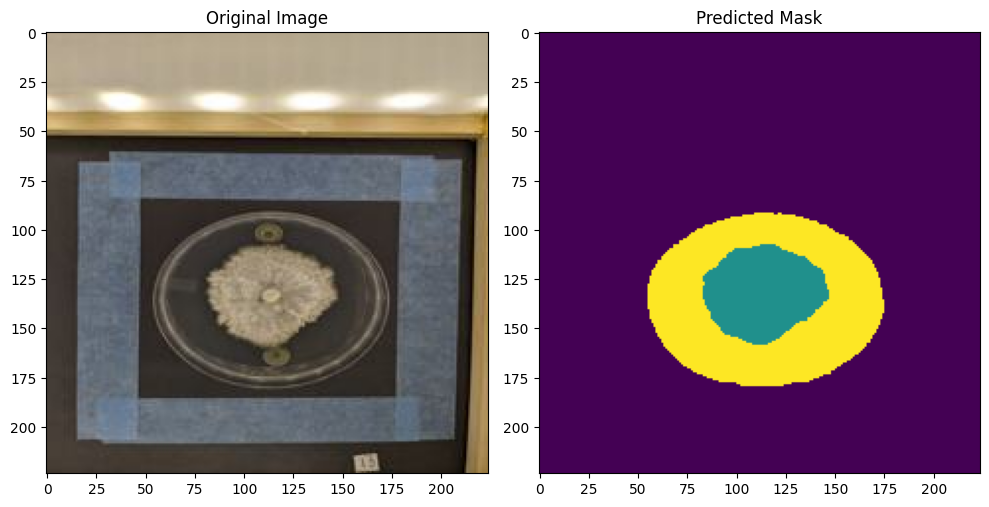

In [29]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Pick which index in the inference dataset you want to visualize
idx = 5  

# Grab the image and filename from your inference dataset
image, filename = inference_dataset[idx]

# Convert the image tensor to a format Matplotlib can display
# (Channels-Last ordering and a NumPy array):
image_np = image.permute(1,2,0).numpy()

# Build the path to the predicted mask that was saved
pred_mask_path = os.path.join("labels/automated_labels_2", f"{os.path.splitext(filename)[0]}_pred.png")

# Load the predicted mask from disk
pred_mask_img = Image.open(pred_mask_path)

# Plot side by side
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(image_np)

plt.subplot(1,2,2)
plt.title("Predicted Mask")
plt.imshow(pred_mask_img)

plt.tight_layout()
plt.show()
